In [10]:
import numpy as np
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.optimizers import *
from keras.models import load_model
import matplotlib.pyplot as plt
from music21 import chord, instrument, converter, note, stream
import glob
from tensorflow.keras.utils import to_categorical
from keras.layers import BatchNormalization as BatchNorm
import time
import random

print("DONE")

DONE


In [ ]:


notes = []
start_time = time.time()
for file in glob.glob("dane_treningowe/midi_all/*.mid"):
    midi = converter.parse(file)
    parts = instrument.partitionByInstrument(midi)

    if parts:
        for part in parts:
            if part.getInstrument() is not None:
                instrument_name = part.getInstrument().instrumentName
                if instrument_name == "Acoustic Guitar":
                    notes_to_parse = part.recurse()
                    chord_notes = []
                    for element in notes_to_parse:
                        if isinstance(element, note.Note):
                            notes.append(str(element.pitch))
                        elif isinstance(element, chord.Chord):
                            chord_notes = [str(n) for n in element.normalOrder]
                            chord_str = '.'.join(chord_notes)
                            notes.append(chord_str)

with open("midi_all.txt", "w") as file:
    for note_item in notes:
        file.write(note_item + " ")
end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time_minutes = elapsed_time / 60
print(f"Czas wykonywania programu: {elapsed_time_minutes} minut") 
print("DONE")


In [12]:
notes = []
data1 = []
with open('mala_baza.txt', 'r') as file:
    data = file.read().split()

for item in data:
    data1.append(item)

lm = int(0.05 * len(data1))

for item in range(lm):
    notes.append(data1[item])
    


print("DONE")

DONE


In [ ]:
print(notes[:100])

In [13]:
pitchnames = sorted(set(item for item in notes)) # zbiór unikalnych akordów i nut
n_vocab = len(pitchnames) #ilosc unikalnych nut i akordów
#słownik, przypisanie nutom ich odpowiednich liczb
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
print("DONE")

DONE


In [14]:
#wejscia i wyjścia sieci
network_input = []
network_output = []
network = []
seq = 50 # dlugosc sekwencji wejsciowej 10,25,50,100
sequence_length = seq + 1

for i in range(0, len(notes) - sequence_length):  
    sequence = notes[i:i + sequence_length]
    network.append(sequence)

random.shuffle(network)

for j in range(len(network)):
    sequence_in = network[j][:(sequence_length - 1)]
    sequence_out = network[j][sequence_length - 1]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
    n_patterns = len(network_input)


print("DONE")

DONE


In [15]:
# normalizacja danych wejściowych
network_input = np.reshape(network_input, (n_patterns, seq, 1)) 
network_input = network_input / float(n_vocab) # od 0 do 1
network_output = to_categorical(network_output) # one-hot encoding
print("Kształt danych wejściowych (network_input):", network_input.shape)
print("Kształt danych wyjściowych (network_output):", network_output.shape)
# print(network_output)
network_input_train = network_input[: int(0.7*len(network_input))]
network_output_train = network_output[:int(0.7*len(network_output))]

network_input_val = network_input[int(0.7*len(network_input)):int(0.85*len(network_input))]
network_output_val = network_output[int(0.7*len(network_output)):int(0.85*len(network_output))]

network_input_test = network_input[int(0.85*len(network_input)):]
network_output_test = network_output[int(0.85*len(network_output)):]
print("Kształt danych wejściowych treningowych :", network_input_train.shape)
print("Kształt danych wyjściowych treningowych :", network_output_train.shape)
print("Kształt danych wejściowych walidacyjnych :", network_input_val.shape)
print("Kształt danych wyjściowych walidacyjnych :", network_output_val.shape)
print("Kształt danych wejściowych testowych :", network_input_test.shape)
print("Kształt danych wyjściowych testowych :", network_output_test.shape)

Kształt danych wejściowych (network_input): (28886, 50, 1)
Kształt danych wyjściowych (network_output): (28886, 334)
Kształt danych wejściowych treningowych : (20220, 50, 1)
Kształt danych wyjściowych treningowych : (20220, 334)
Kształt danych wejściowych walidacyjnych : (4333, 50, 1)
Kształt danych wyjściowych walidacyjnych : (4333, 334)
Kształt danych wejściowych testowych : (4333, 50, 1)
Kształt danych wyjściowych testowych : (4333, 334)


In [16]:
# tworzenie modelu
activation = 'relu'
optimizer = 'rmsprop' # 'rmsprop'Adam
loss='categorical_crossentropy'
num_of_neurons = 512 # 20, 50, 100, 200
num_of_layers = 2
#model = Sequential()
#model.add(LSTM(num_of_neurons, activation=activation, input_shape=(network_input_train.shape[1], network_input_train.shape[2]), return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(num_of_neurons, activation=activation, return_sequences=False)) 
#model.add(Dropout(0.2))
#model.add(Dense(n_vocab, activation='softmax')) 
model = Sequential()
model.add(LSTM(
    256,
    input_shape=(network_input_train.shape[1], network_input_train.shape[2]),
    recurrent_dropout=0.3,
    return_sequences=True # return sequence instead fo matrix
))
model.add(LSTM(512, return_sequences=True, recurrent_dropout=0.3))
model.add(LSTM(512))
model.add(BatchNorm())
model.add(Dropout(0.3))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNorm())
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()
print("DONE")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50, 256)           264192    
                                                                 
 lstm_7 (LSTM)               (None, 50, 512)           1574912   
                                                                 
 lstm_8 (LSTM)               (None, 512)               2099200   
                                                                 
 batch_normalization_2 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                      

In [121]:
# checkpoint - zapisanie najlepszego modelu
epochs = 120
batch_size = 64
#file_name = f'MODEL_GRU_{num_of_neurons}neurons_{epochs}epochs_{batch_size}batchsize_{seq}seq_len_{num_of_layers}_num_of_layers.hdf5'
file_name = "weights-improvement-{epoch:02d}-{loss:.4f}-bigger_NOMINALNY_.hdf5"
checkpoint = ModelCheckpoint(file_name, save_best_only=True, monitor='accuracy', verbose=0)
print("DONE")

DONE


In [ ]:
# trening
history = model.fit(network_input_train, network_output_train, epochs=epochs, batch_size=batch_size, validation_data=(network_input_val, network_output_val), callbacks=[checkpoint])
print("DONE")

In [ ]:
#loaded_model = load_model('MODEL_2lstm_25neurons_25epochs_100batchsize_seq100.hdf5')

#try:
#    history = loaded_model.history
#except AttributeError:
#    print("Model nie posiada historii trenowania.")
#    history = None

if history is not None:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Wykres val_accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Model Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend(loc='lower right')

    plt.show()
else:
    print("Brak dostępnej historii trenowania.")


In [122]:
model = load_model("models/MODEL_200neurons_120epochs_100batchsize_10seq_len_2_num_of_layers.hdf5")
print("DONEE")

DONEE


In [125]:
# generowanie nowych nut
number_of_notes = 60
start = np.random.randint(0, len(network_input) - sequence_length - 1)
#start = 11
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = network_input[start]
prediction_output = []
for note_index in range(number_of_notes):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1)) # normalizacja 
    prediction = model.predict(prediction_input, verbose=0)
    index = np.argmax(prediction)
    pattern = np.append(pattern, index)
    pattern = pattern[1:]
    result = int_to_note[index]
    prediction_output.append(result)    
print("DONE")
print("______________________")
print(prediction_output)
print(len(prediction_output))
print("______________________")


DONE
______________________
['A3', '3.5.9', '7.10.0.3', '5.7.0', '10.0.2.5', '10.11.0.4', '6.9.11.2', '7.10.1.3', '7.10.0.3', '7.10.0', '7.10.1', '2.6.7', '8.11.2', '7.10.1.3', '7.10.0', '6.9.11.2', '2.4.6.9', '8.11.2', '11.1.3.6', '1.4.6', '1.4.6', '6.9.11', '5.7.10', '6.9.11', '7.10.1', '10.11.0.4', '3.4', '7.10.1', '7.10.1', '4.7.9', '10.0.5', '10.11.0.4', '2.5.7', '1.4.6', '7.10.1.3', '0.3.5.8', '8.11.2', '7.9.1', '2.5.8.10', '10.0.2.5', '1.4.6', '10.11.0.4', '7.9.0', '11.1.4', '7.10.1', '11.1.6', '0.3.5.8', '3.6.10', '8.11.2', '8.11.2', '7.10.0.3', '2.5.8.10', '0.3.5.8', '10.11.0.4', '8', '3.4', '7.9.0', '8.11.2', '11.1.4', '2.5.8.10']
60
______________________


In [ ]:
print(prediction_output)

In [131]:
# tworzenie nut i akordów
offset = 0  # przesuniecie nut lub akordów (czas)
output_notes = []

for item in prediction_output:
    # szukanie akordów
    offset += 0.5
    if ('.' in item):
        notes_in_chord = item.split('.')
      #  print(notes_in_chord)
        notes12 = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = guitar
            notes12.append(new_note)
        new_chord = chord.Chord(notes12)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # nuta
    else:
        if not item.isnumeric():
          #   print(item)
             new_note = note.Note(item)
             new_note.offset = offset
             new_note.storedInstrument = guitar
             output_notes.append(new_note)
       # new_note = note.Note(item)
       # new_note.offset = offset
       # new_note.storedInstrument = instrument.AcousticGuitar()
       # output_notes.append(new_note)

    

print("DONE")

DONE


(50.0, 80.0)

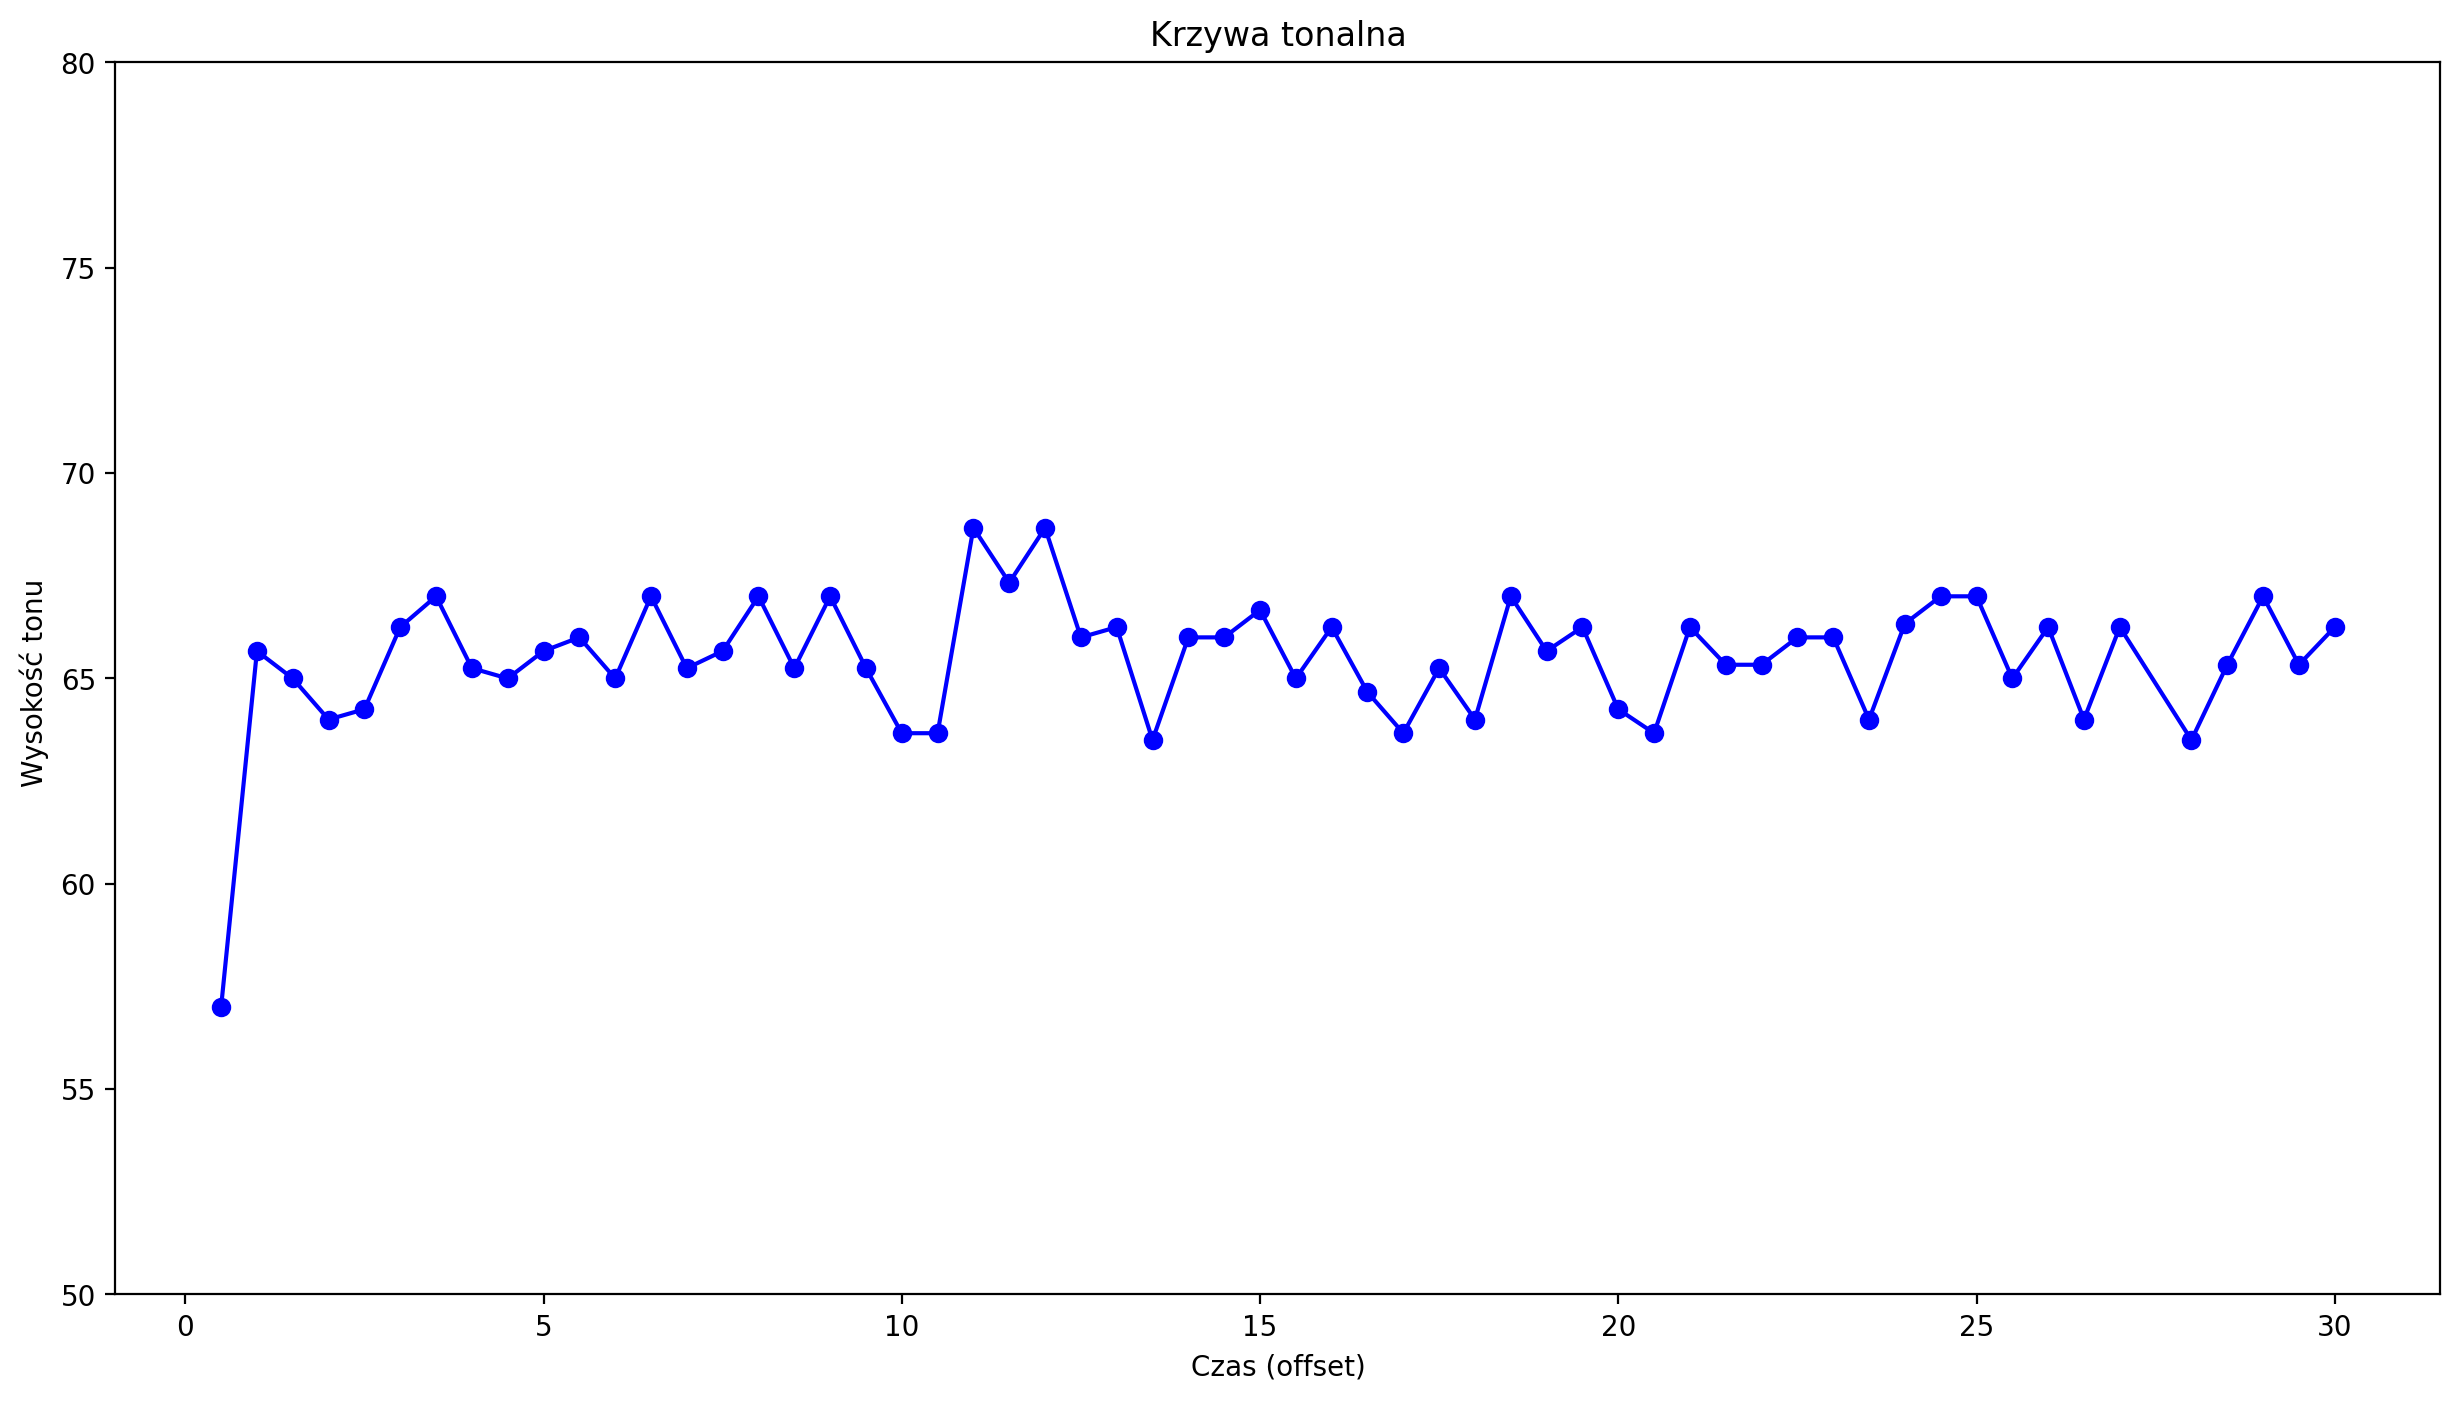

In [132]:

offsets = []
pitches = []

for item in output_notes:
    if isinstance(item, note.Note):
        offsets.append(item.offset)
        pitches.append(item.pitch.midi)
    elif isinstance(item, chord.Chord):
        chord_pitches = [note_in_chord.pitch.midi for note_in_chord in item.notes]
        avg_pitch = sum(chord_pitches) / len(chord_pitches) # dla akordów liczona jest średnia arytmetyczna
        offsets.append(item.offset)
        pitches.append(avg_pitch)

plt.figure(figsize=(15, 8))
plt.plot(offsets, pitches, marker='o', linestyle='-', color='b')
plt.title('Krzywa tonalna')
plt.xlabel('Czas (offset)')
plt.ylabel('Wysokość tonu ')

# Ustaw zakres osi Y
plt.ylim(50, 80)


In [135]:
# tworzenie pliku midi
#offset = 0
file_out = f'MODEL{num_of_neurons}neurons_{epochs}epochs_{batch_size}batchsize_{seq}seq_len_{num_of_layers}_num_of_layers.mid'

midi_stream = stream.Stream()

guitar = instrument.Guitar()  
midi_stream.append(guitar)

for item in output_notes:
    if isinstance(item, note.Note) or isinstance(item, chord.Chord):
        # Ustaw instrument dla każdej nuty i akordu
        item.storedInstrument = guitar
      #  item.offset = offset
        midi_stream.append(item)
        #offset += 0.5
        
file_out = f'MODEL{num_of_neurons}neurons_{epochs}epochs_{batch_size}batchsize_{seq}seq_len_{num_of_layers}_num_of_layers.mid'
midi_stream.write('midi', fp=file_out)
print("DONE")



DONE


In [101]:
mf = converter.parse(file_out)
mf.show('midi')

In [ ]:
print(prediction_output)